In [1]:
# environment set up
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Reshape, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import metrics
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import ast
from scipy import stats as st
import time

In [2]:
# working folder = "/Users/Srikar/Desktop/Velexi/spectra-ml/data"

spectrum_len = 500 # automate this
parent_dir = os.environ['PWD']
stddata_path = os.path.join(os.environ['DATA_DIR'], "StdData-" + str(spectrum_len))
os.chdir(os.path.join(parent_dir, "lab-notebook", "smunukutla"))

In [3]:
# data extraction

data = pd.read_csv("data.csv", sep=",")
record_nums = data.iloc[0, :].tolist()
spectrum_names = data.iloc[1, :].tolist()
y = data.iloc[2, :].astype(int).tolist()
y = np.reshape(y, (len(y), 1))
num_samples = len(y)

In [4]:
spectra = np.zeros((num_samples,spectrum_len))

# wavelengths = np.zeros((1,spectrum_len))
# y = np.zeros((num_samples, 1))

In [5]:
for i in range(len(record_nums)):
    data = pd.read_csv(os.path.join(stddata_path,"{}.csv".format(record_nums[i])))
#     if i == 0:
#         wavelengths[i,:] = data.iloc[:, 0].to_numpy()
    spectra[i,:] = data.iloc[:, 1].to_numpy()

In [6]:
y_cat = to_categorical(y)

In [7]:
fi = open("indices.txt", "r")
num_runs = int(fi.readline())
num_minerals = int(fi.readline())

stats = []

init_time = time.time()

for i in range(num_runs):
    train_set_indices = ast.literal_eval(fi.readline())
    test_set_indices = ast.literal_eval(fi.readline())
    dev_set_indices = ast.literal_eval(fi.readline())
    
    for j in train_set_indices:
        j = int(j)
    for k in test_set_indices:
        k = int(k)
    for m in dev_set_indices:
        m = int(m)
    
    train_set = spectra[train_set_indices, :]
#     train_labels = y[train_set_indices, :]
    dev_set = spectra[dev_set_indices, :]
#     dev_labels = y[dev_set_indices, :]
    test_set = spectra[test_set_indices, :]
#     test_labels = y[test_set_indices, :]

#     train_labels = train_labels.flatten()
#     dev_labels = dev_labels.flatten()
#     test_labels = test_labels.flatten()

    train_set = np.reshape(train_set, (train_set.shape[0], spectrum_len, 1))
    dev_set = np.reshape(dev_set, (dev_set.shape[0], spectrum_len, 1))
    test_set = np.reshape(test_set, (test_set.shape[0], spectrum_len, 1))

#     train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
#     dev_labels = np.reshape(dev_labels, (dev_labels.shape[0], 1))
#     test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

#     train_labels = to_categorical(train_labels)
#     dev_labels = to_categorical(dev_labels)
#     test_labels = to_categorical(test_labels)

    train_labels = y_cat[train_set_indices, :]
    dev_labels = y_cat[dev_set_indices, :]
    test_labels = y_cat[test_set_indices, :]
    
#     print(train_labels)
    
    model = Sequential() # tf upgrading to 2.0, after that we need to specify the dtype/construct all layers at once
    # model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
    model.add(Conv1D(64, 25, activation='relu', input_shape=(train_set.shape[1], 1))) # optional: , dtype=tf.dtypes.float64
    model.add(Conv1D(64, 25, activation='relu'))
    model.add(MaxPooling1D(4)) # 108 by 64 so far
#     model.add(Conv1D(100, 25, activation='relu'))
#     model.add(Conv1D(100, 25, activation='relu'))
#     model.add(MaxPooling1D(4))
    # model.add(Dropout(0.5))
    # model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    model.add(Dense(num_minerals, activation='softmax'))
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    BATCH_SIZE = 32
    EPOCHS = 80
    
#     checkpointer = ModelCheckpoint(filepath="model.h5",
#                                verbose=0,
#                                save_best_only=True)
#     tensorboard = TensorBoard(log_dir='./logs',
#                           histogram_freq=0,
#                           write_graph=True,
#                           write_images=True)

#     history = model.fit(train_set, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0, validation_data=(dev_set, dev_labels), callbacks=[checkpointer, tensorboard]).history
    model.fit(train_set, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0, validation_data=(dev_set, dev_labels))
    preds = model.evaluate(test_set, test_labels, verbose=0)

#     print(tf.keras.losses.categorical_crossentropy())
    
#     print(model.predict(test_set))
    
#     print(model.layers[0].get_weights())

#     from tensorflow.keras import backend as K

#     # with a Sequential model
#     get_3rd_layer_output = K.function([model.layers[0].input],
#                                       [model.layers[7].output])
#     layer_output = get_3rd_layer_output(dev_set)
#     print(layer_output)
    
#     print(dev_labels[13])
#     print(dev_set[13])
    
    stats.append(preds[1])

# print("1D CNN:", stats)
print("1D CNN Results:", st.describe(stats))
total_seconds = time.time() - init_time
print(total_seconds)

W1125 14:39:27.043610 4625276352 deprecation.py:506] From /Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 476, 64)           1664      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 452, 64)           102464    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 113, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7232)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                72330     
Total params: 176,458
Trainable params: 176,458
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

In [8]:
# # random.seed()
# model = Sequential()
# # model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
# model.add(Conv1D(64, 25, activation='relu', input_shape=(train_set.shape[1], 1)))
# model.add(Conv1D(64, 25, activation='relu'))
# model.add(MaxPooling1D(4)) # 108 by 64 so far
# model.add(Conv1D(100, 25, activation='relu'))
# model.add(Conv1D(100, 25, activation='relu'))
# model.add(MaxPooling1D(4))
# # model.add(Dropout(0.5))
# # model.add(GlobalAveragePooling1D())
# model.add(Flatten())
# model.add(Dense(3, activation='softmax'))
# print(model.summary())

In [9]:
loaded_model = load_model('model.h5')

W1105 16:12:00.666545 4448664896 deprecation.py:506] From /Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1105 16:12:00.668367 4448664896 deprecation.py:506] From /Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


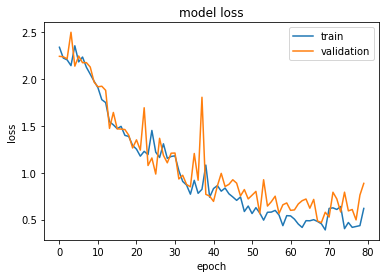

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

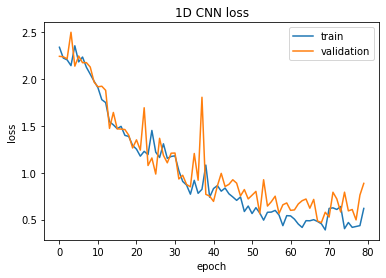

In [11]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('1D CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [13]:
history

{'loss': [2.336364584739762,
  2.221622440550062,
  2.202459607461486,
  2.1409457934023153,
  2.352328659308077,
  2.180551211039225,
  2.2323474691371725,
  2.1237024875602337,
  2.0495841057613644,
  1.9743389722072717,
  1.9059355066280173,
  1.7783365538626006,
  1.7472841318207557,
  1.5433566088628288,
  1.5095463401139384,
  1.4690954600921784,
  1.4937581462089462,
  1.3974998153821387,
  1.386315982751172,
  1.290282621528163,
  1.2507705796848645,
  1.17604897028268,
  1.2274127680845934,
  1.1930339781924932,
  1.450063219576171,
  1.2188777526219685,
  1.1619760604819867,
  1.3078938493824968,
  1.1532803075482148,
  1.1727923227078987,
  1.1798610607481965,
  1.0210214570315197,
  0.9068268224446461,
  0.868156074122949,
  0.7709372832317545,
  0.9185654719670614,
  0.7798734105596639,
  0.8231290313932631,
  1.0811569925510522,
  0.7389537631863295,
  0.8311853023490521,
  0.8623805750500072,
  0.8029566027901389,
  0.8360162600122317,
  0.7749438875853413,
  0.741490461

In [14]:
model.save('1dcnn.h5')